# 1 - Getting Started

_Welcome to GPlately!_

GPlately uses object-oriented programming to make life simple. In this notebook we will explore some of the main objects you will use:

- `PlateReconstruction` - reconstruct features, tesselate mid ocean ridges, subduction zones
- `Points` - partition points onto plates, rotate back through time
- `Raster` - read in NetCDF grids, interpolation, resampling.
- `PlotTopologies` - one stop shop for plotting ridges, trenches, subduction teeth

In [1]:
import gplately

import numpy as np
import pygplates
import glob, os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

Presently, we still have to point to these data. In the future, a set of topologies, rotation files, age grids, etc. could be downloaded from a server.

In [2]:
# Input rotation and topology files.
agegrid_dir = "/home/ben/Dropbox/USyd/GPlates/SampleData/Rasters/M2020_AgeGrids/"
input_directory = "/home/ben/Dropbox/USyd/GPlates/SampleData/Muller_etal_2019_PlateMotionModel_v2.0_Tectonics/"

rotation_filenames = glob.glob(os.path.join(input_directory, '*.rot'))
rotation_model = pygplates.RotationModel(rotation_filenames)

coastlines = input_directory+"StaticGeometries/Coastlines/Global_coastlines_2019_v1_low_res.shp"
continents = input_directory+"StaticGeometries/ContinentalPolygons/Global_EarthByte_GPlates_PresentDay_ContinentalPolygons_2019_v1.shp"
static_polygons = input_directory+"StaticGeometries/StaticPolygons/Global_EarthByte_GPlates_PresentDay_StaticPlatePolygons_2019_v1.shp"
COBs = input_directory+"StaticGeometries/COBLineSegments/Global_EarthByte_GeeK07_COBLineSegments_2019_v1.shp"

topology_filenames = glob.glob(os.path.join(input_directory, '*.gpml'))
topology_features = pygplates.FeatureCollection()
for topology_filename in topology_filenames:
    if "Inactive" not in topology_filename:
        topology_features.add( pygplates.FeatureCollection(topology_filename) )
    else:
        topology_filenames.remove(topology_filename)


# Tessellate the subduction zones to 0.5 degrees.
tessellation_threshold_radians = np.radians(0.05)

extent_globe = [-180,180,-90,90]
agegrid_filename = "Muller_etal_2019_Tectonics_v2.0_AgeGrid-{:.0f}.nc"

## Making plate reconstructions

We simply supply a rotation model, plate topologies, and static polygons to initialise a plate reconstruction model.

In [3]:
model = gplately.PlateReconstruction(rotation_model, topology_features, static_polygons)

Now let's find the subduction zones and mid-ocean ridges at 10 Ma.

In [4]:
time = 10

# these bundle a lot of information - check PTT docs for more info
subduction_data = model.tesselate_subduction_zones(time)
ridge_data = model.tesselate_mid_ocean_ridges(time)

## Plotting

The `PlotTopologies` function injests the plate model we have defined as well as the coastlines, continents, and COB. It computes all of the plate topologies for a given reconstruction time.

This object has been designed to work specifically with `cartopy`. Define your figure and supply your axes to these plotting routines. Some common favourites include:

- coastlines
- continents
- ridges and transforms
- trenches
- subduction teeth (!!)
- netCDF grids
- plate motion vectors

You can still supply optional keywords as you normally would.

In [5]:
time = 10

gplot = gplately.plot.PlotTopologies(model, time, coastlines, continents, COBs)

/home/ben/.local/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1841: UserWarning: Some vectors at source domain corners may not have been transformed correctly
  u, v = self.projection.transform_vectors(t, x, y, u, v)


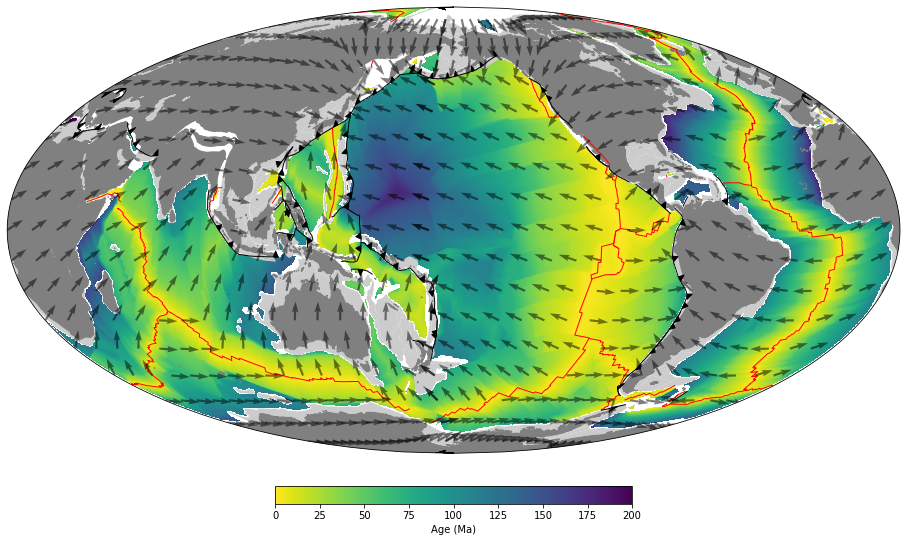

In [6]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(190))

gplot.plot_continents(ax1, facecolor='0.8')
gplot.plot_coastlines(ax1, color='0.5')
gplot.plot_ridges_and_transforms(ax1, color='red')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')
im =gplot.plot_grid_from_netCDF(ax1, agegrid_dir+agegrid_filename.format(time), cmap='viridis_r', vmin=0, vmax=200)
gplot.plot_plate_motion_vectors(ax1, spacingX=10, spacingY=10, normalise=True, zorder=10, alpha=0.5)

fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Age (Ma)')

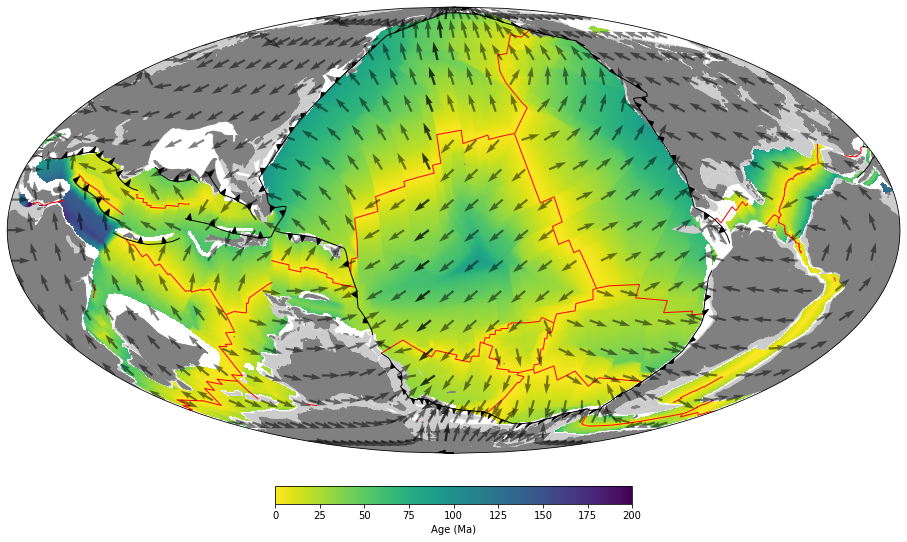

In [7]:
# update the time to regenerate topologies
gplot.time = 100

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(111, projection=ccrs.Mollweide(190))

gplot.plot_continents(ax1, facecolor='0.8')
gplot.plot_coastlines(ax1, color='0.5')
gplot.plot_ridges_and_transforms(ax1, color='red')
gplot.plot_trenches(ax1, color='k')
gplot.plot_subduction_teeth(ax1, color='k')
im =gplot.plot_grid_from_netCDF(ax1, agegrid_dir+agegrid_filename.format(gplot.time), cmap='viridis_r', vmin=0, vmax=200)
gplot.plot_plate_motion_vectors(ax1, spacingX=10, spacingY=10, normalise=True, zorder=10, alpha=0.5)

fig.colorbar(im, orientation='horizontal', shrink=0.4, pad=0.05, label='Age (Ma)')

## Working with points

Now that we have defined our reconstruction object, we can reconstruct point data.

In [12]:
pt_lons = np.array([140., 150., 160.])
pt_lats = np.array([-30., -40., -50.])

gpts = gplately.Points(model, pt_lons, pt_lats)

vel_x, vel_y = gpts.plate_velocity(0)
vel_mag = np.hypot(vel_x, vel_y)

print("average point velocity (cm/yr)", vel_mag)

average point velocity (cm/yr) [6.38389518 5.71007208 5.06602802]


Plot their position from `time=0` to `time=20`

In [13]:
rlons = np.empty((21, pt_lons.size))
rlats = np.empty((21, pt_lons.size))


for time in range(0, 21):
    rlons[time], rlats[time] = gpts.reconstruct(time)

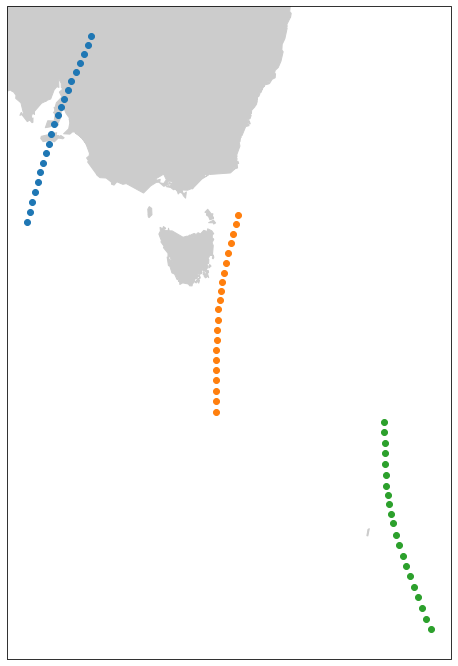

In [14]:
gplot.time = 0 # present day

fig = plt.figure(figsize=(16,12))
ax1 = fig.add_subplot(111, projection=ccrs.Mercator(190))

gplot.plot_coastlines(ax1, color='0.8')

for i in range(0, len(pt_lons)):
    ax1.plot(rlons[:,i], rlats[:,i], 'o', transform=ccrs.PlateCarree())

## Rasters

You can initialise a `Raster` object from a NetCDF file path or a regular numpy array. The `data` attribute stores the raster data as a 2D numpy array.

In [15]:
time = 0

graster = gplately.Raster(agegrid_dir+agegrid_filename.format(time))

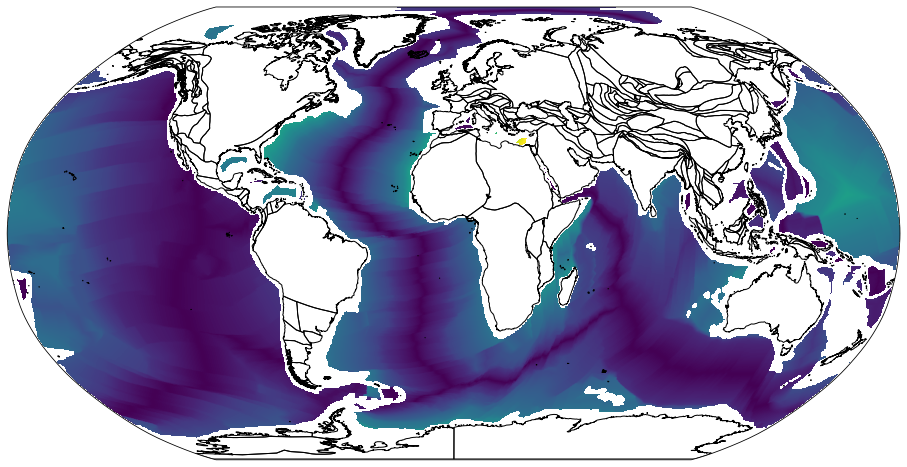

In [16]:
gplot.time = time

fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(111, projection=ccrs.Robinson())
gplot.plot_grid(ax1, graster.data)
gplot.plot_coastlines(ax1, edgecolor='k', facecolor='none')

There are a bunch of routines such as,

- filling masked (NaN) regions
- interpolation
- resampling

In-place operations can be achieved using `overwrite=True` which will update the internal data structures.

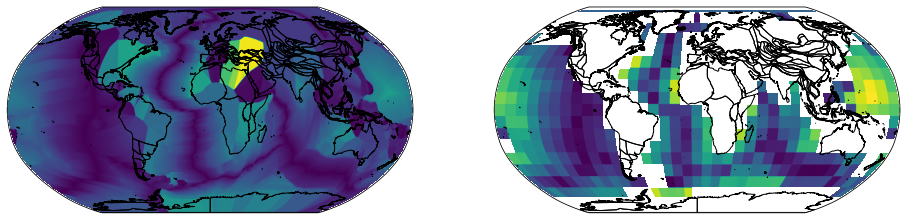

In [17]:
filled_data = graster.fill_NaNs(overwrite=False)
downsampled_data = graster.resample(spacingX=10, spacingY=10, overwrite=False)



fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(1,2,1, projection=ccrs.Robinson())
gplot.plot_grid(ax1, filled_data)
gplot.plot_coastlines(ax1, edgecolor='k', facecolor='none')

ax2 = fig.add_subplot(1,2,2, projection=ccrs.Robinson())
gplot.plot_grid(ax2, downsampled_data)
gplot.plot_coastlines(ax2, edgecolor='k', facecolor='none')